In [1]:
!pip install --quiet bitnet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not installed.
cudf 24.10.1 requires ptxcompiler, which is not installed.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml 24.10.0 requires nvidia-cublas, which is not installed.
cuml 24.10.0 requires nvidia-cufft, which is not installed.
cuml 24.10.0 requires nvidia-curand, which is not installed.
cuml 24.10.0 requires nvidia-cusolver, which is not installed.
cuml 24.10.0 requires nvidia-cusparse, which is not installed.
dask-cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but

In [ ]:
from API import WANDB_TOKEN, HP_TOKEN
DATASET           = "dennlinger/eur-lex-sum"
model_name        = "MikaSie/LegalBERT_BART_fixed_V1"
CONTEXT_LENGTH    = 256

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset
from bitnet import replace_linears_in_hf
from tqdm import tqdm 
import torch
import wandb

wandb.init(project="summarization", name="LegalBERT_BART_fixed_V1_quantized", config={
    "model_name": "MikaSie/LegalBERT_BART_fixed_V1",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "max_length": 150,
    "num_beams": 4
})

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

model_size = sum(t.numel() for t in model.parameters())
print(f"Model size before quantization: {model_size / 1000 ** 2:.1f}M parameters")


model = torch.quantization.quantize_dynamic( 
    model,                                 # Quantize the model for inference (dynamic quantization)
    {torch.nn.Linear},                     # Quantize only the Linear layers for faster inference
    dtype=torch.qint8                      # Use 8-bit integer quantization
)

model_size = sum(t.numel() for t in model.parameters())
print(f"Model size after quantization: {model_size / 1000 ** 2:.1f}M parameters")

model.to(device)

data         = load_dataset("dennlinger/eur-lex-sum", "english", trust_remote_code=True)
texts        = data['test']['reference']
gt_summaries = data['test']['summary']
summaries    = []

for idx, text in tqdm(enumerate(texts),total = len(texts)):

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=CONTEXT_LENGTH).to(device)
    
    
    model.eval()          # Evaluation mode 
    with torch.no_grad(): # Perform inference
        outputs = model.generate(**inputs, max_length=CONTEXT_LENGTH, num_beams=4, early_stopping=True)
    
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    summaries.append(summary)

    wandb.log({
        f"summary_{idx + 1}": summary,
        f"input_{idx + 1}": text,
        f"length_of_summary_{idx + 1}": len(summary.split())
    })

wandb.finish()

2024-12-16 14:32:14.646 | INFO     | zeta.nn.modules.flow_transformer:__init__:221 - Initializing Flow Transformer with config: FlowTransformerConfig(dim=512, heads=8, depth=6, seq_length=1024, flow_hidden_dim=128, flow_steps=4, dropout=0.1, attention_dropout=0.1, learning_rate=0.0001, vocab_size=50000, weight_decay=0.01, warmup_steps=10000, max_steps=100000, batch_size=32, checkpoint_interval=1000, device=device(type='cuda'))
2024-12-16 14:32:14.938 | DEBUG    | zeta.nn.modules.flow_transformer:__init__:74 - Initialized FlowMLP with architecture: Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (2): GELU(approximate='none')
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (5): GELU(approximate='none')
  (6): Linear(in_features=128, out_features=512, bias=True)
)
2024-12-16 14:32:14.959 | DEBUG    | zeta.nn.modules.flow_transfor

Input shape: torch.Size([4, 512])
Output shape: torch.Size([4, 512, 50000])
Predictions shape: torch.Size([4, 512])


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

Model size before quantization: 406.3M parameters
Model size after quantization: 53.7M parameters


README.md:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

eur-lex-sum.py:   0%|          | 0.00/4.45k [00:00<?, ?B/s]

train.json:   0%|          | 0.00/93.9M [00:00<?, ?B/s]

validation.json:   0%|          | 0.00/24.1M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

100%|██████████| 188/188 [46:39<00:00, 14.89s/it]


length_of_summary_1,▁
length_of_summary_10,▁
length_of_summary_100,▁
length_of_summary_101,▁
length_of_summary_102,▁
length_of_summary_103,▁
length_of_summary_104,▁
length_of_summary_105,▁
length_of_summary_106,▁
length_of_summary_107,▁
length_of_summary_108,▁


In [4]:
!pip install --quiet bert-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
from bert_score import score

P, R, F1 = score(summaries,gt_summaries, model_type="bert-base-uncased", lang="en")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
import numpy as np 
print("\nBERTScore Model Benchmark Results:")
print(f"Precision: Mean = {torch.mean(P):.4f}, Std = {torch.std(P):.4f}")
print(f"Recall   : Mean = {torch.mean(R):.4f}, Std = {torch.std(R):.4f}")
print(f"F1-score : Mean = {torch.mean(R):.4f}, Std = {torch.std(R):.4f}")


BERTScore Model Benchmark Results:
Precision: Mean = 0.5185, Std = 0.0223
Recall   : Mean = 0.4246, Std = 0.0172
F1-score : Mean = 0.4246, Std = 0.0172


In [7]:
!pip install --quiet rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
from rouge_score import rouge_scorer
from tqdm import tqdm 

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store scores
bitnet_rouge1_scores, bitnet_rouge2_scores, bitnet_rougeL_scores = [], [], []

for summary, gt_summary in tqdm(zip(summaries, gt_summaries), total=len(summaries)):
    # Generate summary
    scores = scorer.score(gt_summary, summary)
    bitnet_rouge1_scores.append(scores['rouge1'].fmeasure)
    bitnet_rouge2_scores.append(scores['rouge2'].fmeasure)
    bitnet_rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate BLEU score
    reference = gt_summary.split()  # Tokenized reference summary
    candidate = summary.split()  # Tokenized generated summary

import numpy as np

# Calculate mean and standard deviation for each metric
bitnet_rouge1_mean, bitnet_rouge1_std = np.mean(bitnet_rouge1_scores), np.std(bitnet_rouge1_scores)
bitnet_rouge2_mean, bitnet_rouge2_std = np.mean(bitnet_rouge2_scores), np.std(bitnet_rouge2_scores)
bitnet_rougeL_mean, bitnet_rougeL_std = np.mean(bitnet_rougeL_scores), np.std(bitnet_rougeL_scores)

print("\nBitNet Model Full Precision Benchmark Results:")
print(f"ROUGE-1: Mean = {bitnet_rouge1_mean:.4f}, Std = {bitnet_rouge1_std:.4f}")
print(f"ROUGE-2: Mean = {bitnet_rouge2_mean:.4f}, Std = {bitnet_rouge2_std:.4f}")
print(f"ROUGE-L: Mean = {bitnet_rougeL_mean:.4f}, Std = {bitnet_rougeL_std:.4f}")

100%|██████████| 188/188 [00:18<00:00,  9.91it/s]


BitNet Model Full Precision Benchmark Results:
ROUGE-1: Mean = 0.2370, Std = 0.0510
ROUGE-2: Mean = 0.0687, Std = 0.0164
ROUGE-L: Mean = 0.1546, Std = 0.0279


# Baseline 

In [9]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
summaries = [] 
for idx, text in tqdm(enumerate(texts),total = len(texts)):

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=CONTEXT_LENGTH).to(device)
    
    model.eval()          # Evaluation mode 
    with torch.no_grad(): # Perform inference
        outputs = model.generate(**inputs, max_length=CONTEXT_LENGTH, num_beams=4, early_stopping=True)
    
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    summaries.append(summary)
    
    scores = scorer.score(gt_summary, summary)
    bitnet_rouge1_scores.append(scores['rouge1'].fmeasure)
    bitnet_rouge2_scores.append(scores['rouge2'].fmeasure)
    bitnet_rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate BLEU score
    reference = gt_summary.split()  # Tokenized reference summary
    candidate = summary.split()  # Tokenized generated summary

100%|██████████| 188/188 [1:32:24<00:00, 29.49s/it]


In [14]:
summaries = summaries[-188:]

In [15]:
P, R, F1 = score(summaries,gt_summaries, model_type="bert-base-uncased", lang="en")
print("\nBERTScore Model Benchmark Results:")
print(f"Precision: Mean = {torch.mean(P):.4f}, Std = {torch.std(P):.4f}")
print(f"Recall   : Mean = {torch.mean(R):.4f}, Std = {torch.std(R):.4f}")
print(f"F1-score : Mean = {torch.mean(R):.4f}, Std = {torch.std(R):.4f}")

# Calculate mean and standard deviation for each metric
bitnet_rouge1_mean, bitnet_rouge1_std = np.mean(bitnet_rouge1_scores), np.std(bitnet_rouge1_scores)
bitnet_rouge2_mean, bitnet_rouge2_std = np.mean(bitnet_rouge2_scores), np.std(bitnet_rouge2_scores)
bitnet_rougeL_mean, bitnet_rougeL_std = np.mean(bitnet_rougeL_scores), np.std(bitnet_rougeL_scores)

print("\nBitNet Model Full Precision Benchmark Results:")
print(f"ROUGE-1: Mean = {bitnet_rouge1_mean:.4f}, Std = {bitnet_rouge1_std:.4f}")
print(f"ROUGE-2: Mean = {bitnet_rouge2_mean:.4f}, Std = {bitnet_rouge2_std:.4f}")
print(f"ROUGE-L: Mean = {bitnet_rougeL_mean:.4f}, Std = {bitnet_rougeL_std:.4f}")


BERTScore Model Benchmark Results:
Precision: Mean = 0.6857, Std = 0.0358
Recall   : Mean = 0.5825, Std = 0.0306
F1-score : Mean = 0.5825, Std = 0.0306

BitNet Model Full Precision Benchmark Results:
ROUGE-1: Mean = 0.2105, Std = 0.0465
ROUGE-2: Mean = 0.0633, Std = 0.0157
ROUGE-L: Mean = 0.1323, Std = 0.0307


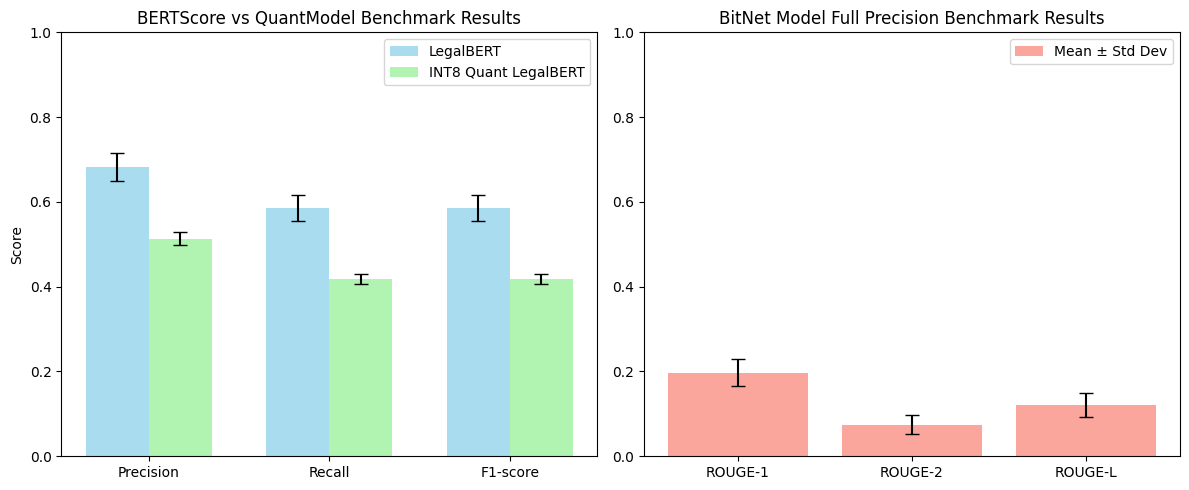

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Data for BERTScore Model Benchmark Results
bert_metrics = ['Precision', 'Recall', 'F1-score']
bert_means = [0.6822, 0.5855, 0.5855]
bert_stds = [0.0334, 0.0317, 0.0317]

# Data for BERTScore QuantModel Benchmark Results
quant_means = [0.5135, 0.4186, 0.4186]
quant_stds = [0.0160, 0.0120, 0.0120]

# Data for BitNet Model Full Precision Benchmark Results
bitnet_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
bitnet_means = [0.1971, 0.0749, 0.1210]
bitnet_stds = [0.0318, 0.0216, 0.0275]

# Plotting the bar charts
x = np.arange(len(bert_metrics))  # The label locations
width = 0.35  # Width of the bars

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# BERTScore and QuantModel combined bar chart
axs[0].bar(x - width/2, bert_means, width, yerr=bert_stds, capsize=5, color='skyblue', alpha=0.7, label='LegalBERT')
axs[0].bar(x + width/2, quant_means, width, yerr=quant_stds, capsize=5, color='lightgreen', alpha=0.7, label='INT8 Quant LegalBERT')
axs[0].set_title('BERTScore vs QuantModel Benchmark Results')
axs[0].set_xticks(x)
axs[0].set_xticklabels(bert_metrics)
axs[0].set_ylabel('Score')
axs[0].set_ylim(0, 1)
axs[0].legend()

# BitNet bar chart
x_bitnet = np.arange(len(bitnet_metrics))
axs[1].bar(x_bitnet, bitnet_means, yerr=bitnet_stds, capsize=5, color='salmon', alpha=0.7, label='Mean ± Std Dev')
axs[1].set_title('BitNet Model Full Precision Benchmark Results')
axs[1].set_xticks(x_bitnet)
axs[1].set_xticklabels(bitnet_metrics)
axs[1].set_ylim(0, 1)
axs[1].legend()

plt.tight_layout()
plt.show()


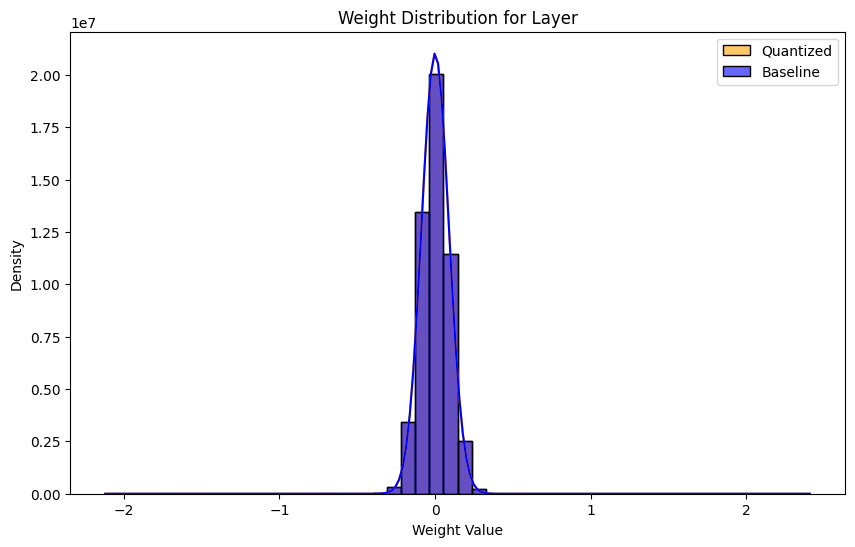

In [20]:
import matplotlib.pyplot as plt 
import seaborn as sns 

layer_weights   = []
baseline_model  = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
quantized_model = model 

for (_, baseline_param), (_, quantized_param) in zip(baseline_model.named_parameters(),quantized_model.named_parameters()):
    if baseline_param.requires_grad and quantized_param.requires_grad:
        baseline_weights = baseline_param.data.flatten()
        quantized_weights = quantized_param.data.flatten()
        layer_weights.append((baseline_weights, quantized_weights))


baseline_weights, quantized_weights = layer_weights[0]
plt.figure(figsize=(10, 6))
sns.histplot(quantized_weights.cpu().numpy(), color='orange', label='Quantized', kde=True, bins=50, alpha=0.6)
sns.histplot(baseline_weights.cpu().numpy(), color='blue', label='Baseline', kde=True, bins=50, alpha=0.6)

plt.title(f"Weight Distribution for Layer")
plt.xlabel("Weight Value")
plt.ylabel("Density")
plt.legend()
plt.show()